# COMP47670 Assignment 2 - Text Classification

#### Student Name: Dara Leonard
#### Student ID: 19202478

In [133]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

## Task 1: Scrape all reviews for each category and store them as three separate datasets
For Task 1 I have chosen the Automotive, Cafes, and Fashion categories as my data sources.

The following four methods extract the review data from the data source (Yalp) and parses it out into three pandas
data frames, one for each of the chosen categories. 

In [134]:
data_source = 'http://mlg.ucd.ie/modules/yalp/'
business_categories = ['automotive_list.html', 'cafes_list.html', 'fashion_list.html']

def extract_category_data(url):
    response = requests.get(url)
    data = response.text
    return BeautifulSoup(data,'html.parser')


def categorise_rating(review_stars):
    return 'positive' if int(review_stars.get('alt').split('-')[0]) >= 4 else 'negative'


def extract_reviews(url):
    soup = extract_category_data(url)
    reviews_block = soup.findAll('div', { 'class' : 'review' })
    review_list =[]
    review_info_columns = ['comment', 'rating']
    review_df = pd.DataFrame(columns=review_info_columns)

    for i, reviews in enumerate(reviews_block):
        review = {}
        review_stars = reviews.find('img')
        review['comments'] = reviews.find('p', { 'class' : 'review-text' }).get_text()
        review['rating'] = categorise_rating(review_stars)
        review_list.append(review)        
        
        review_tmp = dict({
            'comment': reviews.find('p', { 'class' : 'review-text' }).get_text(),
            'rating' : categorise_rating(review_stars)
        })
        review_df.loc[i] = review_tmp

    return review_list, review_df


def extract_data(url):
    soup = extract_category_data(url)
    links = soup.find_all('a')
    review_list =[]
    for link in links:
        url = data_source + link.get('href')
        review, review_df = extract_reviews(url)
        review_list.append(review_df)
    return pd.concat(review_list)


automotive_url = data_source + business_categories[0]
cafe_url = data_source + business_categories[1]
fashion_url = data_source + business_categories[2]

automotive_reviews_df = extract_data(automotive_url)
cafe_reviews_df = extract_data(cafe_url)
fashion_reviews_df = extract_data(fashion_url)

The following chunk of logic is dumping the data out to a json file. This will allow the program to be ran in a shorter
amount of time by just reading the already collected data and performing the analysis. 

In [135]:
automotive_reviews_df.to_json('automotive.json', orient='records')
cafe_reviews_df.to_json('cafe.json', orient='records')
fashion_reviews_df.to_json('fashion.json', orient='records')

Re-read the data from the data already collected from Yalp

In [136]:
consolidated_automotive_reviews_df = pd.read_json('automotive.json', orient='records')
consolidated_cafe_reviews_df = pd.read_json('cafe.json', orient='records')
consolidated_fashion_reviews_df = pd.read_json('fashion.json', orient='records')

Display a snapshot of each of the data frames

In [137]:
consolidated_automotive_reviews_df.head()

,comment,rating
0,The man that was working tonight (8-12-17) was...,negative
1,Chris is a very rude person. Gave me an attitu...,negative
2,One of my favorite gas station to stop at. The...,positive
3,Oh thank Heaven for Seven Eleven! I don't know...,negative
4,Five stars because of the guy who works weekda...,positive


In [138]:
consolidated_cafe_reviews_df.head()

,comment,rating
0,Pros: Lots of items you would not expect from ...,positive
1,Best egg-tarts in town! There's really not muc...,positive
2,I've been to ABC Bakery a few times since I re...,negative
3,"FYI, Closed Monday's New ownership for about 1...",negative
4,The inside may not look like much but they mak...,positive


In [139]:
consolidated_fashion_reviews_df.head()

,comment,rating
0,Looking for the best tactical supplies? Look n...,positive
1,Stood in line like an idiot for 5 minutes to p...,negative
2,Another great store with quality Equipment. Th...,positive
3,The Problem with this store is not that they h...,positive
4,Great place! We went in at almost closing time...,positive


Check to see the dimensions of each of the data frames

In [140]:
consolidated_automotive_reviews_df.shape

(2000, 2)

In [141]:
consolidated_cafe_reviews_df.shape

(2000, 2)

In [142]:
consolidated_fashion_reviews_df.shape

(2000, 2)

Do a check to see if there's any missing data

In [143]:
consolidated_automotive_reviews_df.isnull().sum()

comment    0
rating     0
dtype: int64

In [144]:
consolidated_cafe_reviews_df.isnull().sum()

comment    0
rating     0
dtype: int64

In [145]:
consolidated_fashion_reviews_df.isnull().sum()

comment    0
rating     0
dtype: int64

Do a check on the nature of the reviews to see the ratio of positive to negative

In [146]:
consolidated_automotive_reviews_df.groupby('rating')['rating'].count()

rating
negative     788
positive    1212
Name: rating, dtype: int64

In [147]:
consolidated_cafe_reviews_df.groupby('rating')['rating'].count()

rating
negative     538
positive    1462
Name: rating, dtype: int64

In [148]:
consolidated_fashion_reviews_df.groupby('rating')['rating'].count()

rating
negative     795
positive    1205
Name: rating, dtype: int64

## Task 2: For each of the chosen categories; apply any necessary pre-processing, build a classification model & test said classification model


### 2.1 Normalise Data 
The following five methods are tasked with pre-processing the data:
1. remove_stop_words - Remove the stopwords in the review like 'is', 'an', etc. They do not contribute to the efficiency of the classifier
2. remove_numeric_special - Remove any special and numeric characters
3. converted_strings_to_lowercase - convert all characters in every review to lower case
4. lemmatize - Sort words in each review so as to group together inflected or variant forms of the same word.
5. preprocess_data_frame - Calls each of the methods specified above

In [149]:
def remove_stop_words(data_frame):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    data_frame['comment']=data_frame['comment'].apply(lambda i:  pattern.sub('', i) if len(i) > 0 else i ) 
    
    return data_frame


def remove_numeric_special(data_frame):
    data_frame['comment']=data_frame['comment'].apply(lambda i:  re.sub('[^A-Za-z]+', ' ', i)  if len(i) > 0 else i ) 
    return data_frame 


def converted_strings_to_lowercase(data_frame):
    data_frame['comment']=data_frame['comment'].str.lower()
    return data_frame 

def lemmatize(data_frame):
    lemmatizer = WordNetLemmatizer()       
    data_frame['comment'] = data_frame['comment'].apply(lambda j: ''.join([lemmatizer.lemmatize(i) for i in j]))
    return data_frame


def preprocess_data_frame(data_frame):
    preprocessed_data_frame = remove_stop_words(data_frame)
    preprocessed_data_frame = remove_numeric_special(preprocessed_data_frame)
    preprocessed_data_frame = converted_strings_to_lowercase(preprocessed_data_frame)
    return lemmatize(preprocessed_data_frame)


### 2.2 Merging the dataset to build the classifier

Merging the three data sets to form a unified dataset before normailising the data using the functions written in Task 2.1.

In [150]:
combined_data_frame = consolidated_automotive_reviews_df.append(consolidated_cafe_reviews_df).append(consolidated_fashion_reviews_df)

cleaned_combined_data = preprocess_data_frame(combined_data_frame)

Get a description of the data to see counts, unique count etc.

In [151]:
cleaned_combined_data.describe()

,comment,rating
count,6000,6000
unique,6000,2
top,excellent addition charming downtown mount hor...,positive
freq,1,3879


Preview the new data set to see all words have been normalised

In [152]:
cleaned_combined_data.head()

,comment,rating
0,the man working tonight rude a real jerk i nee...,negative
1,chris rude person gave attitude change some pe...,negative
2,one favorite gas station stop the store always...,positive
3,oh thank heaven seven eleven i know i thank se...,negative
4,five stars guy works weekday mornings around a...,positive


### 2.3 Choosing the classifier
Let's run some quick experiments to see which of the three available classifiers are the most accurate on one of the data sets.
I am using the automotive category only in these experiments

Before building the models, I'm defining a function to display the performance metrics of each model based on their confusion matrix

In [153]:
def evaluate_model_performance(confusion_matrix):
    total = sum(sum(confusion_matrix))

    true_negative, false_negative = confusion_matrix[0][0], confusion_matrix[1][0]
    true_positive, false_positive = confusion_matrix[1][1], confusion_matrix[0][1]
    
    print(f'Confusion Matrix: \
      \n \t \t| Positive | Negative \
      \n Positive \t| {true_negative} \t| {false_positive} \
      \n Negative \t| {false_negative} \t| {true_positive}')

    accuracy = (true_negative + true_positive)/ total
    print('Accuracy: {:.2f}%'.format(accuracy*100))

    error_rate = 1 - accuracy
    print('Error rate: {:.2f}%'.format(error_rate*100))

    sensitivity = true_positive/(true_positive + false_negative)
    print('Sensitivity: {:.2f}%'.format(sensitivity*100))

    false_positive_rate = false_positive/(true_negative + false_positive)
    print('False positive rate: {:.2f}%'.format(false_positive_rate*100))
    
    specificity = true_negative/(true_negative + false_positive)
    print('Specificity: {:.2f}%'.format(specificity*100))
    
    precision = true_positive/(false_positive + true_positive)
    print('Precision rate: {:.2f}%'.format(precision*100))
    
    prevalence = (false_negative + true_positive)/total
    print('Prevalence rate: {:.2f}%'.format(prevalence*100))

#### 2.3.1 Logistic Regression

Create a TfidfVectorizer to create a numeric representation of the dataset and set the target value for the classifier

In [154]:
tfidf_vectorizer = TfidfVectorizer()
corpus = cleaned_combined_data['comment']
X_merged = tfidf_vectorizer.fit_transform(corpus)
y_merged = cleaned_combined_data['rating']
X_merged.shape

(6000, 18910)

Now I will split the data to use the automotive category data to build the experimental models

In [155]:
X_automotiveReviewSize = consolidated_automotive_reviews_df.shape[0]
X_automotive = X_merged[:X_automotiveReviewSize]
target_automotive = y_merged[:X_automotiveReviewSize]

Identify the dimensions of the separated data set to ensure they match what they were previously

In [156]:
X_automotive.shape

(2000, 18910)

Partition the data to use for the classifier. I chose a standard split of 70% training and 30% test data

In [157]:
automotive_data_train, automotive_data_test, automotive_target_train, automotive_target_test = train_test_split(X_automotive, target_automotive, test_size=0.3, shuffle=True)

Display the shapes of the training and testing data sets 

In [158]:
print('Automotive training data set size: %d' % automotive_data_train.shape[0])
print('Automotive test data set size: %d ' % automotive_data_test.shape[0])

Automotive training data set size: 1400
Automotive test data set size: 600 


Train each of the models using each of the training data sets and then use the test data to test said models

In [159]:
automotive_model_log_reg = linear_model.LogisticRegression(solver='liblinear')
automotive_model_log_reg.fit(automotive_data_train, automotive_target_train)

predicted_automotive_log_reg = automotive_model_log_reg.predict(automotive_data_test)

#### 2.3.2 Naive Bayes

Build a Naive Bayes model with the same training data as used in the logistic regression classifier and then use the 
test data to test said model

In [160]:
automotive_model_naive_bayes = MultinomialNB().fit(automotive_data_train, automotive_target_train)

predicted_automotive_naive_bayes = automotive_model_naive_bayes.predict(automotive_data_test)

#### 2.3.3 Random Forests
Build a Random Forests model with the same training data as used in the logistic regression and naive bayes classifiers above

To get the best results from the Random Forests model some parameter tuning is required. To do this GridSearchCV can be used
to tune the hyper parameters

In [161]:
random_forest = RandomForestClassifier()

random_forest_param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50],
    'n_estimators': [100, 200, 300, 500]
}

grid_search = GridSearchCV(estimator = random_forest, param_grid = random_forest_param_grid, n_jobs = -1, verbose = 2)
grid_search.fit(automotive_data_train, automotive_target_train) 

automotive_model_score_random_forest = grid_search.best_estimator_
automotive_model_score_random_forest.fit(automotive_data_test, automotive_target_test) 


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [162]:
predicted_automotive_random_forest = automotive_model_score_random_forest.predict(automotive_data_test)

After building each of the classifiers with the automotive data set, the metrics for each model can now be gathered

#### Logistic Regression Metrics

In [163]:
evaluate_model_performance(confusion_matrix(automotive_target_test, predicted_automotive_log_reg, labels=['positive','negative']))
print(classification_report(automotive_target_test, predicted_automotive_log_reg, target_names=['negative','positive']))
automotive_model_cross_validation_score_log_reg =  cross_val_score(automotive_model_log_reg, X_automotive, target_automotive, cv=10, scoring='accuracy')
print('Mean cross-validation accuracy of the logistic regression model: %.2f' % automotive_model_cross_validation_score_log_reg.mean())

Confusion Matrix:       
 	 	| Positive | Negative       
 Positive 	| 345 	| 20       
 Negative 	| 49 	| 186
Accuracy: 88.50%
Error rate: 11.50%
Sensitivity: 79.15%
False positive rate: 5.48%
Specificity: 94.52%
Precision rate: 90.29%
Prevalence rate: 39.17%
              precision    recall  f1-score   support

    negative       0.90      0.79      0.84       235
    positive       0.88      0.95      0.91       365

    accuracy                           0.89       600
   macro avg       0.89      0.87      0.88       600
weighted avg       0.89      0.89      0.88       600

Mean cross-validation accuracy of the logistic regression model: 0.89


#### Naive Bayes Metrics

In [164]:
evaluate_model_performance(confusion_matrix(automotive_target_test, predicted_automotive_naive_bayes, labels=['positive','negative']))
print(classification_report(automotive_target_test, predicted_automotive_naive_bayes, target_names=['negative','positive']))
automotive_model_cross_validation_score_naive_bayes =  cross_val_score(automotive_model_naive_bayes, X_automotive, target_automotive, cv=10, scoring='accuracy')
print('Mean cross-validation accuracy of the Naive Bayes model: %.2f' % automotive_model_cross_validation_score_naive_bayes.mean())

Confusion Matrix:       
 	 	| Positive | Negative       
 Positive 	| 364 	| 1       
 Negative 	| 160 	| 75
Accuracy: 73.17%
Error rate: 26.83%
Sensitivity: 31.91%
False positive rate: 0.27%
Specificity: 99.73%
Precision rate: 98.68%
Prevalence rate: 39.17%
              precision    recall  f1-score   support

    negative       0.99      0.32      0.48       235
    positive       0.69      1.00      0.82       365

    accuracy                           0.73       600
   macro avg       0.84      0.66      0.65       600
weighted avg       0.81      0.73      0.69       600

Mean cross-validation accuracy of the Naive Bayes model: 0.77


#### Random Forest Metrics

In [165]:
evaluate_model_performance(confusion_matrix(automotive_target_test, predicted_automotive_random_forest, labels=['positive','negative']))
print(classification_report(automotive_target_test, predicted_automotive_random_forest, target_names=['negative','positive']))
automotive_model_cross_validation_score_random_forest =  cross_val_score(automotive_model_score_random_forest, X_automotive, target_automotive, cv=10, scoring='accuracy')
print('Mean cross-validation accuracy of the Random Forests model: %.2f' % automotive_model_cross_validation_score_random_forest.mean())

Confusion Matrix:       
 	 	| Positive | Negative       
 Positive 	| 365 	| 0       
 Negative 	| 0 	| 235
Accuracy: 100.00%
Error rate: 0.00%
Sensitivity: 100.00%
False positive rate: 0.00%
Specificity: 100.00%
Precision rate: 100.00%
Prevalence rate: 39.17%
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       235
    positive       1.00      1.00      1.00       365

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Mean cross-validation accuracy of the Random Forests model: 0.85


Now the accuracy of each of the models can be plotted

I have chosen 10-fold cross validation as the classification evaluation metric as it trains and tests on all data available.

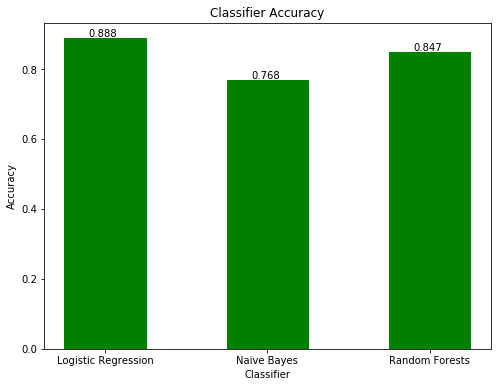

In [166]:
accuracy_results = [automotive_model_cross_validation_score_log_reg.mean(), automotive_model_cross_validation_score_naive_bayes.mean(), automotive_model_cross_validation_score_random_forest.mean()]
index = np.arange(len(accuracy_results))
plt.figure(figsize=(8,6))
bar_list = plt.bar(index, accuracy_results, width=0.5)
for bar in bar_list:
    yval = round(bar.get_height(), 3)
    plt.text(bar.get_x()+0.15, yval + .005, yval)

bar_list[0].set_color('g')
bar_list[1].set_color('g')
bar_list[2].set_color('g')

plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.xticks(index, ['Logistic Regression', 'Naive Bayes', 'Random Forests'])
plt.title('Classifier Accuracy')
plt.show()

From the results above, the logistic regression model has a slightly better accuracy than the one built using Random Forests.
Random Forests did have have a better accuracy according to its confusion matrix, but I felt like 10-fold cross validation was
a better metric to go by. It was also a lot more computationally expensive due to the parameter tuning. 

##### 2.3 Building each of the logistic regression models using each of the chosen categories

First the cafe and fashion data needs to be extracted from the merged data set

In [167]:
X_cafeReviewSize = consolidated_cafe_reviews_df.shape[0]
X_fashionReviewSize = consolidated_fashion_reviews_df.shape[0]

X_cafe = X_merged[X_automotiveReviewSize:X_automotiveReviewSize + X_cafeReviewSize]
target_cafe = y_merged[X_automotiveReviewSize:X_automotiveReviewSize + X_cafeReviewSize]

X_fashion = X_merged[X_automotiveReviewSize + X_cafeReviewSize:]
target_fashion = y_merged[X_automotiveReviewSize + X_cafeReviewSize:]


Then a quick inspection is done of each of these data sets to ensure they are the correct size

In [168]:
X_cafe.shape

(2000, 18910)

In [169]:
X_fashion.shape

(2000, 18910)

Then the model for each of the other two categories can be built

In [170]:
cafe_data_train, cafe_data_test, cafe_target_train, cafe_target_test = train_test_split(X_cafe, target_cafe, test_size=0.3, shuffle=True)
fashion_data_train, fashion_data_test, fashion_target_train, fashion_target_test = train_test_split(X_fashion, target_fashion, test_size=0.3, shuffle=True)

cafe_model_log_reg = linear_model.LogisticRegression(solver='liblinear')
cafe_model_log_reg.fit(cafe_data_train, cafe_target_train)

fashion_model_log_reg = linear_model.LogisticRegression(solver='liblinear')
fashion_model_log_reg.fit(fashion_data_train, fashion_target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [171]:
automotive_model_cross_validation_score_log_reg =  cross_val_score(automotive_model_log_reg, X_automotive, target_automotive, cv=10, scoring='accuracy')
print('Mean cross-validation accuracy of the logistic regression model - automotive: %.2f' % automotive_model_cross_validation_score_log_reg.mean())

cafe_model_cross_validation_score_log_reg =  cross_val_score(cafe_model_log_reg, X_cafe, target_cafe, cv=10, scoring='accuracy')
print('Mean cross-validation accuracy of the logistic regression model - cafe: %.2f' % cafe_model_cross_validation_score_log_reg.mean())

fashion_model_cross_validation_score_log_reg =  cross_val_score(fashion_model_log_reg, X_fashion, target_fashion, cv=10, scoring='accuracy')
print('Mean cross-validation accuracy of the logistic regression model - fashion: %.2f' % fashion_model_cross_validation_score_log_reg.mean())

Mean cross-validation accuracy of the logistic regression model - automotive: 0.89
Mean cross-validation accuracy of the logistic regression model - cafe: 0.82
Mean cross-validation accuracy of the logistic regression model - fashion: 0.85


Based on the results above, a graph of the accuracy of each of the models can be produced

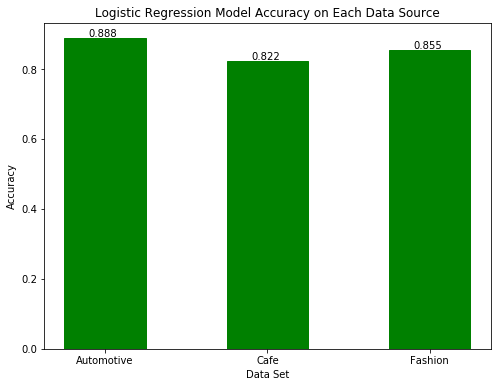

In [172]:
log_reg_accuracy_results = [automotive_model_cross_validation_score_log_reg.mean(), cafe_model_cross_validation_score_log_reg.mean(), fashion_model_cross_validation_score_log_reg.mean()]
log_reg_index = np.arange(len(log_reg_accuracy_results))
plt.figure(figsize=(8,6))
bar_list_log_reg_accuracy_results = plt.bar(index, log_reg_accuracy_results, width=0.5)
for bar in bar_list_log_reg_accuracy_results:
    y_val = round(bar.get_height(), 3)
    plt.text(bar.get_x()+0.15, y_val + .005, y_val)

bar_list_log_reg_accuracy_results[0].set_color('g')
bar_list_log_reg_accuracy_results[1].set_color('g')
bar_list_log_reg_accuracy_results[2].set_color('g')

plt.xlabel('Data Set')
plt.ylabel('Accuracy')
plt.xticks(index, ['Automotive', 'Cafe', 'Fashion'])
plt.title('Logistic Regression Model Accuracy on Each Data Source')
plt.show()

## Task 3: Evaluate the performance of each classification model when applied to data from the other two selected categories.

Since now the three models are created - automotive_model_log_reg, cafe_model_log_reg, fashion_model_log_reg, Task 3 can be started

10-fold cross validation was again chosen to maintain consistency with the methods used above
### 2.1 Training on automotive data and evaluating on cafe and fashion data

In [173]:
automotive_model_all_data = linear_model.LogisticRegression(solver='liblinear')
automotive_model_all_data.fit(X_automotive, target_automotive)

trained_on_automotive_tested_on_cafe_cv_score =  cross_val_score(automotive_model_all_data, X_cafe, target_cafe, cv=10, scoring='accuracy')
print('Accuracy of model trained on automotive data and tested on cafe data: %.2f' % trained_on_automotive_tested_on_cafe_cv_score.mean())
trained_on_automotive_tested_on_fashion_cv_score =  cross_val_score(automotive_model_all_data, X_fashion, target_fashion, cv=10, scoring='accuracy')
print('Accuracy of model trained on automotive data and tested on fashion data: %.2f' % trained_on_automotive_tested_on_fashion_cv_score.mean())

Accuracy of model trained on automotive data and tested on cafe data: 0.82
Accuracy of model trained on automotive data and tested on fashion data: 0.85


### 2.2 Training on cafe data and evaluating on automotive and fashion data

In [174]:
cafe_model_all_data = linear_model.LogisticRegression(solver='liblinear')
cafe_model_all_data.fit(X_cafe, target_cafe)

trained_on_cafe_tested_on_automotive_cv_score =  cross_val_score(cafe_model_all_data, X_automotive, target_automotive, cv=10, scoring='accuracy')
print('Accuracy of model trained on cafe data and tested on automotive data: %.2f' % trained_on_cafe_tested_on_automotive_cv_score.mean())
trained_on_cafe_tested_on_fashion_cv_score =  cross_val_score(cafe_model_all_data, X_fashion, target_fashion, cv=10, scoring='accuracy')
print('Accuracy of model trained on cafe data and tested on fashion data: %.2f' % trained_on_cafe_tested_on_fashion_cv_score.mean())

Accuracy of model trained on cafe data and tested on automotive data: 0.89
Accuracy of model trained on cafe data and tested on fashion data: 0.85


### 2.3 Training on fashion data and evaluating on automotive and cafe data

In [175]:
fashion_model_all_data = linear_model.LogisticRegression(solver='liblinear')
fashion_model_all_data.fit(X_fashion, target_fashion)

trained_on_fashion_tested_on_automotive_cv_score =  cross_val_score(fashion_model_all_data, X_automotive, target_automotive, cv=10, scoring='accuracy')
print('Accuracy of model trained on fashion data and tested on automotive data: %.2f' % trained_on_fashion_tested_on_automotive_cv_score.mean())
trained_on_fashion_tested_on_cafe_cv_score =  cross_val_score(fashion_model_all_data, X_cafe, target_cafe, cv=10, scoring='accuracy')
print('Accuracy of model trained on fashion data and tested on cafe data: %.2f' % trained_on_fashion_tested_on_cafe_cv_score.mean())

Accuracy of model trained on fashion data and tested on automotive data: 0.89
Accuracy of model trained on fashion data and tested on cafe data: 0.82


### 2.4 Conclusion
The accuracy values of the models are different but comparable when used on a category other than what it was trained on. This is because, each 
category would presumably contain words that correspond only to their category alone. 

Each of the models trained on another category would not have identified these new keywords as an important factor in the classification of each
review as it still gives priority to the keywords it found in the category it was trained on.

It should be noted that the models have shown a comparable accuracy with the data values for a different category as general words contained in a
positive review are always similar no matter what category we choose, likewise with negative reviews.